<a href="https://colab.research.google.com/github/Rabia17/Facial-recognition/blob/main/ASSL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
# Install in Colab if needed
!pip install torch torchvision

import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.utils.data as data_utils
import os

# CONFIG
LABEL_COL = "FormalyDiognosedWithASD"
MAX_ITER = 15
MIN_NEW_SAMPLES = 5
PERCENTILE = 80
OUTPUT_DIR = "integrated_ddt_cdl_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# CNN Model for tabular input
class TabularCNN(nn.Module):
    def __init__(self, input_dim):
        super(TabularCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(16 * input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 2),
            nn.Softmax(dim=1)
        )
    def forward(self, x):
        return self.net(x)

# Dynamic thresholds per class
def get_class_thresholds(preds, probs, percentile=PERCENTILE):
    thresholds = {}
    for cls in np.unique(preds):
        cls_probs = probs[preds == cls]
        if len(cls_probs) > 0:
            thresholds[cls] = np.percentile(cls_probs[:, cls], percentile)
        else:
            thresholds[cls] = 0.85
    return thresholds

# Load data
labeled_df = pd.read_csv("Updated_C2_Datacom.csv")
unlabeled_df = pd.read_csv("unlabelC1_updatedclean.csv")

# Drop unnecessary columns
drop_cols = ['HowDiognosisDone', 'date', 'Class', 'FormalDiognosisRecieved', 'Ethnicity', 'User',
             'Score', 'AutismAgeCategory', 'time', 'month', 'day', 'year', 'id']
labeled_df.drop(columns=[c for c in drop_cols if c in labeled_df.columns], inplace=True)
unlabeled_df.drop(columns=[c for c in drop_cols if c in unlabeled_df.columns], inplace=True)

X_labeled = labeled_df.drop(columns=[LABEL_COL])
y_labeled = labeled_df[LABEL_COL].astype(int)
X_unlabeled = unlabeled_df.drop(columns=[LABEL_COL], errors='ignore').copy()

# Standardization
scaler = StandardScaler()
X_labeled = scaler.fit_transform(X_labeled)
X_unlabeled = scaler.transform(X_unlabeled)

iteration_stats = []

# Get the columns to use for creating DataFrames after inverse transformation
feature_columns = unlabeled_df.drop(columns=[LABEL_COL], errors='ignore').columns

for iteration in range(MAX_ITER):
    print(f"\n🔁 Iteration {iteration+1}")

    # === NB MODEL ===
    nb_model = GaussianNB()
    nb_model.fit(X_labeled, y_labeled)
    nb_probs = nb_model.predict_proba(X_unlabeled)
    nb_preds = np.argmax(nb_probs, axis=1)
    nb_thresh = get_class_thresholds(nb_preds, nb_probs)
    nb_mask = np.array([nb_probs[i, nb_preds[i]] >= nb_thresh[nb_preds[i]] for i in range(len(nb_preds))])

    df_nb_ddt = pd.DataFrame(scaler.inverse_transform(X_unlabeled[nb_mask]), columns=feature_columns)
    df_nb_ddt[LABEL_COL] = nb_preds[nb_mask]
    df_nb_ddt.to_csv(f"{OUTPUT_DIR}/nb_ddt_iter{iteration+1}.csv", index=False)

    # === CNN MODEL ===
    input_dim = X_labeled.shape[1]
    cnn_model = TabularCNN(input_dim).to("cpu")
    X_tensor = torch.tensor(X_labeled, dtype=torch.float32).unsqueeze(1)
    y_tensor = torch.tensor(y_labeled, dtype=torch.long)
    loader = data_utils.DataLoader(data_utils.TensorDataset(X_tensor, y_tensor), batch_size=32, shuffle=True)

    optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()
    cnn_model.train()
    for epoch in range(10):
        for xb, yb in loader:
            optimizer.zero_grad()
            preds = cnn_model(xb)
            loss = loss_fn(preds, yb)
            loss.backward()
            optimizer.step()

    # Predict on unlabeled data
    cnn_model.eval()
    with torch.no_grad():
        X_un_tensor = torch.tensor(X_unlabeled, dtype=torch.float32).unsqueeze(1)
        cnn_probs = cnn_model(X_un_tensor).numpy()
    cnn_preds = np.argmax(cnn_probs, axis=1)
    cnn_thresh = get_class_thresholds(cnn_preds, cnn_probs)
    cnn_mask = np.array([cnn_probs[i, cnn_preds[i]] >= cnn_thresh[cnn_preds[i]] for i in range(len(cnn_preds))])

    df_cnn_ddt = pd.DataFrame(scaler.inverse_transform(X_unlabeled[cnn_mask]), columns=feature_columns)
    df_cnn_ddt[LABEL_COL] = cnn_preds[cnn_mask]
    df_cnn_ddt.to_csv(f"{OUTPUT_DIR}/cnn_ddt_iter{iteration+1}.csv", index=False)

    # === CDL AGREEMENT ===
    agree_mask = (nb_preds == cnn_preds) & nb_mask & cnn_mask
    if agree_mask.sum() < MIN_NEW_SAMPLES:
        print("🛑 Not enough CDL samples. Stopping.")
        break

    X_new = X_unlabeled[agree_mask]
    y_new = nb_preds[agree_mask]  # or cnn_preds (they agree)

    # Add to training set
    X_labeled = np.vstack([X_labeled, X_new])
    y_labeled = np.concatenate([y_labeled, y_new])
    X_unlabeled = np.delete(X_unlabeled, np.where(agree_mask)[0], axis=0)

    df_cdl = pd.DataFrame(scaler.inverse_transform(X_new), columns=feature_columns)
    df_cdl[LABEL_COL] = y_new
    df_cdl.to_csv(f"{OUTPUT_DIR}/cdl_iter{iteration+1}.csv", index=False)

    # Log iteration stats
    iteration_stats.append({
        "Iteration": iteration + 1,
        "NB_DDT_Total": len(df_nb_ddt),
        "NB_DDT_Autistic": (df_nb_ddt[LABEL_COL] == 1).sum(),
        "NB_DDT_NonAutistic": (df_nb_ddt[LABEL_COL] == 0).sum(),
        "CNN_DDT_Total": len(df_cnn_ddt),
        "CNN_DDT_Autistic": (df_cnn_ddt[LABEL_COL] == 1).sum(),
        "CNN_DDT_NonAutistic": (df_cnn_ddt[LABEL_COL] == 0).sum(),
        "CDL_Total": len(df_cdl),
        "CDL_Autistic": (df_cdl[LABEL_COL] == 1).sum(),
        "CDL_NonAutistic": (df_cdl[LABEL_COL] == 0).sum()
    })

# Save summary
summary_df = pd.DataFrame(iteration_stats)
summary_df.to_csv(f"{OUTPUT_DIR}/iteration_summary.csv", index=False)
print("✅ All results saved to:", OUTPUT_DIR)


🔁 Iteration 1

🔁 Iteration 2

🔁 Iteration 3

🔁 Iteration 4

🔁 Iteration 5

🔁 Iteration 6

🔁 Iteration 7

🔁 Iteration 8

🔁 Iteration 9

🔁 Iteration 10

🔁 Iteration 11

🔁 Iteration 12

🔁 Iteration 13

🔁 Iteration 14

🔁 Iteration 15
✅ All results saved to: integrated_ddt_cdl_outputs


In [67]:
import pandas as pd
import glob

# Load CDL files (agreed samples)
cdl_files = glob.glob("integrated_ddt_cdl_outputs/cdl_iter*.csv")
cdl_dfs = [pd.read_csv(file) for file in sorted(cdl_files)]
df_cdl_all = pd.concat(cdl_dfs, ignore_index=True)

# Load CNN DDT files
cnn_ddt_files = glob.glob("integrated_ddt_cdl_outputs/cnn_ddt_iter*.csv")
cnn_ddt_dfs = [pd.read_csv(file) for file in sorted(cnn_ddt_files)]
df_cnn_ddt_all = pd.concat(cnn_ddt_dfs, ignore_index=True)

# Load NB DDT files
nb_ddt_files = glob.glob("integrated_ddt_cdl_outputs/nb_ddt_iter*.csv")
nb_ddt_dfs = [pd.read_csv(file) for file in sorted(nb_ddt_files)]
df_nb_ddt_all = pd.concat(nb_ddt_dfs, ignore_index=True)

# Load original labeled C2 data
df_c2 = pd.read_csv("trainC2_cleaned.csv")

# Combine CDL, CNN DDT, and original C2 data
df_final_train = pd.concat([df_c2 , df_cdl_all], ignore_index=True)

# Shuffle
df_final_train = df_final_train.sample(frac=1, random_state=42).reset_index(drop=True)

# Save
df_final_train.to_csv("final_train_data.csv", index=False)
print("✅ Saved final training dataset as 'final_train_data.csv'")

✅ Saved final training dataset as 'final_train_data.csv'


In [47]:

labeled_df1 = pd.read_csv("Updated_C2_Datacom.csv")
counts = labeled_df1['FormalyDiognosedWithASD'].value_counts()
print(f"Non-Autistic (0): {counts.get(0, 0)}")
print(f"Autistic (1): {counts.get(1, 0)}")


Non-Autistic (0): 1107
Autistic (1): 1107


In [34]:
!pip install catboost


🔹 Random Forest
              precision    recall  f1-score   support

           0     0.6940    0.8921    0.7807       417
           1     0.9206    0.7609    0.8332       686

    accuracy                         0.8105      1103
   macro avg     0.8073    0.8265    0.8069      1103
weighted avg     0.8350    0.8105    0.8133      1103

Brier Score: 0.1406
ECE: 0.3629
AUC: 0.9140

🔹 Logistic Regression
              precision    recall  f1-score   support

           0     0.7217    0.8705    0.7891       417
           1     0.9100    0.7959    0.8491       686

    accuracy                         0.8241      1103
   macro avg     0.8158    0.8332    0.8191      1103
weighted avg     0.8388    0.8241    0.8265      1103

Brier Score: 0.1430
ECE: 0.3605
AUC: 0.9091

🔹 Support Vector Machine
              precision    recall  f1-score   support

           0     0.6685    0.8945    0.7651       417
           1     0.9193    0.7303    0.8140       686

    accuracy                

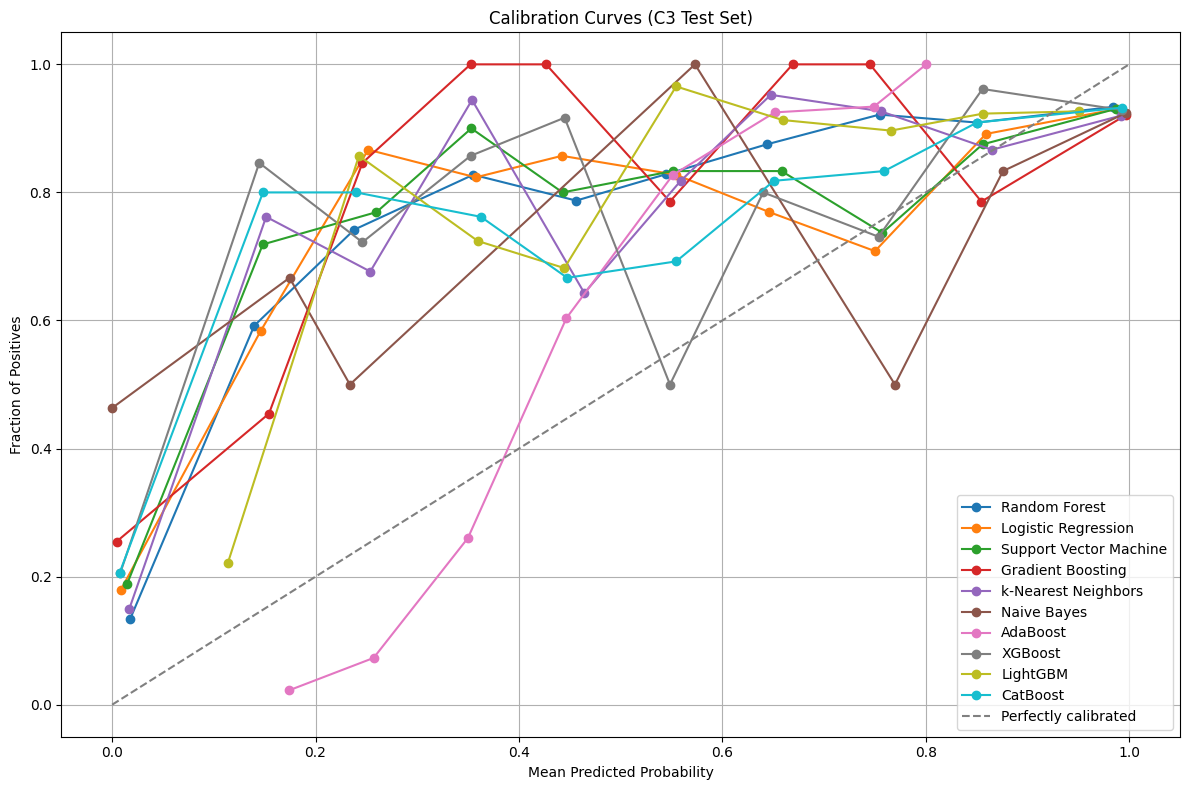

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, brier_score_loss, roc_auc_score
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Function for ECE
def expected_calibration_error(y_true, prob_pos, n_bins=10):
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    binids = np.digitize(prob_pos, bins) - 1
    ece = 0.0
    for i in range(n_bins):
        bin_mask = binids == i
        bin_count = np.sum(bin_mask)
        if bin_count > 0:
            bin_accuracy = np.mean(y_true[bin_mask] == (prob_pos[bin_mask] >= 0.5))
            bin_confidence = np.mean(prob_pos[bin_mask])
            ece += (bin_count / len(y_true)) * abs(bin_accuracy - bin_confidence)
    return ece

# Load final train and test data (merged CDL + C2 already)
df_train = pd.read_csv("final_train_data.csv")  # You should have saved it earlier
df_test = pd.read_csv("Updated_C3_Datanew.csv")

drop_cols = ['HowDiognosisDone', 'date', 'Class', 'FormalDiognosisRecieved', 'Ethnicity', 'User',"Day",
             'Score', 'FamilyASDHistory', 'AutismAgeCategory', 'time', 'month', 'day', 'year', 'id',"DNNPrediction"]
for df in [df_train, df_test]:
    df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True)

X_train = df_train.drop(columns=["FormalyDiognosedWithASD"])
y_train = df_train["FormalyDiognosedWithASD"].astype(int)
X_test = df_test.drop(columns=["FormalyDiognosedWithASD"])
y_test = df_test["FormalyDiognosedWithASD"].astype(int)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=8, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=500, random_state=42),
    'Support Vector Machine': SVC(C=0.1, kernel='rbf', gamma='auto', probability=True, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=150, max_depth=7, subsample=0.6, random_state=42),
    'k-Nearest Neighbors': KNeighborsClassifier(n_neighbors=100, algorithm='auto', leaf_size=100),
    'Naive Bayes': GaussianNB(),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, learning_rate=0.5, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=100, max_depth=6, learning_rate=0.1, subsample=0.8, random_state=42),
    'LightGBM': LGBMClassifier(n_estimators=200, learning_rate=0.01, num_leaves=31, random_state=42),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=0)
}


results = []

plt.figure(figsize=(12, 8))
for name, model in models.items():
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)

    # Metrics
    brier = brier_score_loss(y_test, y_prob)
    ece = expected_calibration_error(y_test.values, y_prob)
    auc = roc_auc_score(y_test, y_prob)

    print(f"\n🔹 {name}")
    print(classification_report(y_test, y_pred, digits=4))
    print(f"Brier Score: {brier:.4f}")
    print(f"ECE: {ece:.4f}")
    print(f"AUC: {auc:.4f}")

    # Save results
    results.append({
        "Model": name,
        "BrierScore": brier,
        "ECE": ece,
        "AUC": auc
    })

    # Plot calibration curve
    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=name)

# Plot perfect calibration line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curves (C3 Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("calibration_curves_all_models.png")
plt.show()

# Save results to CSV
pd.DataFrame(results).to_csv("model_calibration_results.csv", index=False)


✅ Random Forest CV Accuracy: 0.9388 ± 0.0033
✅ Logistic Regression CV Accuracy: 0.9368 ± 0.0036
✅ SVM CV Accuracy: 0.9351 ± 0.0042
✅ Gradient Boosting CV Accuracy: 0.9328 ± 0.0042
✅ KNN CV Accuracy: 0.9349 ± 0.0051
✅ Naive Bayes CV Accuracy: 0.9271 ± 0.0063
✅ AdaBoost CV Accuracy: 0.9369 ± 0.0033
✅ XGBoost CV Accuracy: 0.9358 ± 0.0015
[LightGBM] [Info] Number of positive: 4721, number of negative: 2707
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36
[LightGBM] [Info] Number of data points in the train set: 7428, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.635568 -> initscore=0.556180
[LightGBM] [Info] Start training from score 0.556180
[LightGBM] [Info] Number of positive: 4721, number of negative: 2707
[LightGBM] [Info] Auto-choosing row-wise mu

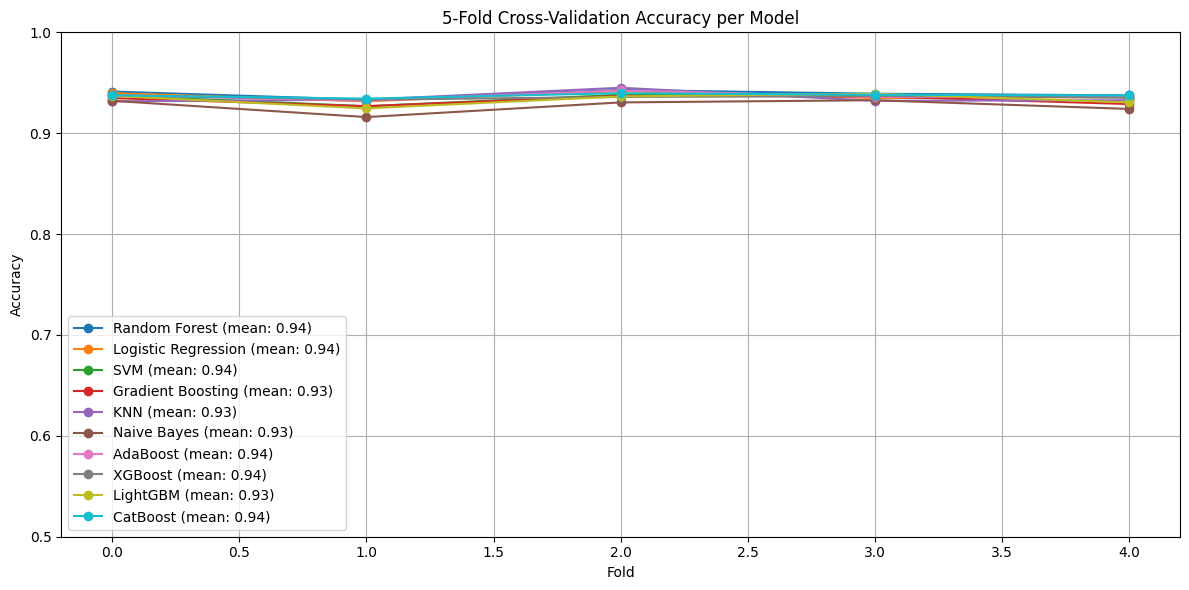

In [41]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
models = {
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=8, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=500, random_state=42),
    'SVM': SVC(C=0.1, kernel='rbf', gamma='auto', probability=True, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=150, max_depth=7, subsample=0.6, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=100),
    'Naive Bayes': GaussianNB(),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, learning_rate=0.5, random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42),
    'LightGBM': LGBMClassifier(n_estimators=200, random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    cv_scores[name] = scores
    print(f"✅ {name} CV Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")
plt.figure(figsize=(12, 6))
for name, scores in cv_scores.items():
    plt.plot(scores, label=f'{name} (mean: {scores.mean():.2f})', marker='o')

plt.title("5-Fold Cross-Validation Accuracy per Model")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.ylim(0.5, 1.0)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("cv_model_accuracies.png")
plt.show()


🔁 CNN Fold 1
🔁 CNN Fold 2
🔁 CNN Fold 3
🔁 CNN Fold 4
🔁 CNN Fold 5


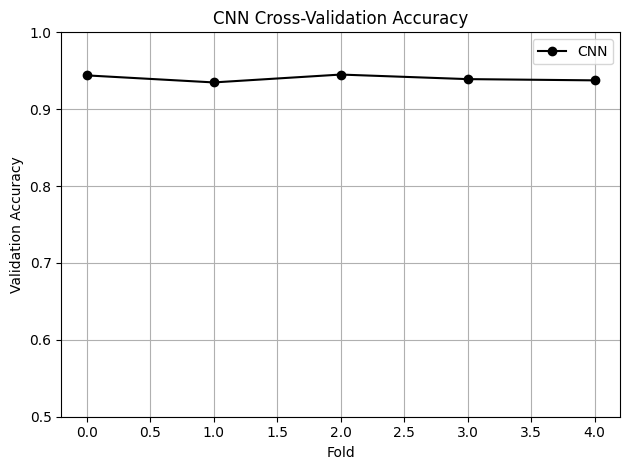

✅ CNN CV Accuracy: 0.9401 ± 0.0039


In [42]:
def create_cnn(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.4),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

cnn_accuracies = []
for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
    print(f"🔁 CNN Fold {fold + 1}")
    X_fold_train, y_fold_train = X_train[train_idx], y_train.values[train_idx]
    X_fold_val, y_fold_val = X_train[val_idx], y_train.values[val_idx]

    cnn_model = create_cnn(X_train.shape[1])
    history = cnn_model.fit(X_fold_train, y_fold_train, epochs=10, batch_size=32,
                            validation_data=(X_fold_val, y_fold_val), verbose=0)
    acc = history.history['val_accuracy'][-1]
    cnn_accuracies.append(acc)

# Plot CNN CV
plt.plot(cnn_accuracies, label="CNN", marker='o', color='black')
plt.title("CNN Cross-Validation Accuracy")
plt.xlabel("Fold")
plt.ylabel("Validation Accuracy")
plt.ylim(0.5, 1.0)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("cnn_cv_accuracy.png")
plt.show()

print(f"✅ CNN CV Accuracy: {np.mean(cnn_accuracies):.4f} ± {np.std(cnn_accuracies):.4f}")


[LightGBM] [Info] Number of positive: 4721, number of negative: 2707
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 110
[LightGBM] [Info] Number of data points in the train set: 7428, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.635568 -> initscore=0.556180
[LightGBM] [Info] Start training from score 0.556180
[LightGBM] [Info] Number of positive: 4721, number of negative: 2707
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 109
[LightGBM] [Info] Number of data points in the train set: 7428, number of used features: 14
[LightGBM] [Info] [binary:Bo

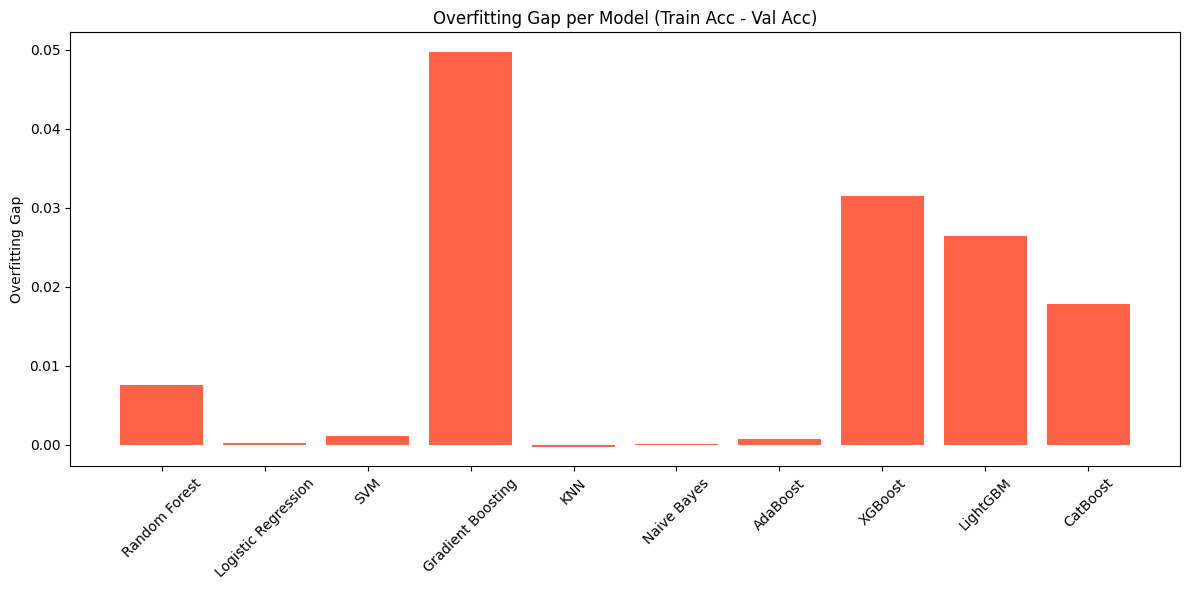

🔁 CNN Fold 1
🔁 CNN Fold 2
🔁 CNN Fold 3
🔁 CNN Fold 4
🔁 CNN Fold 5


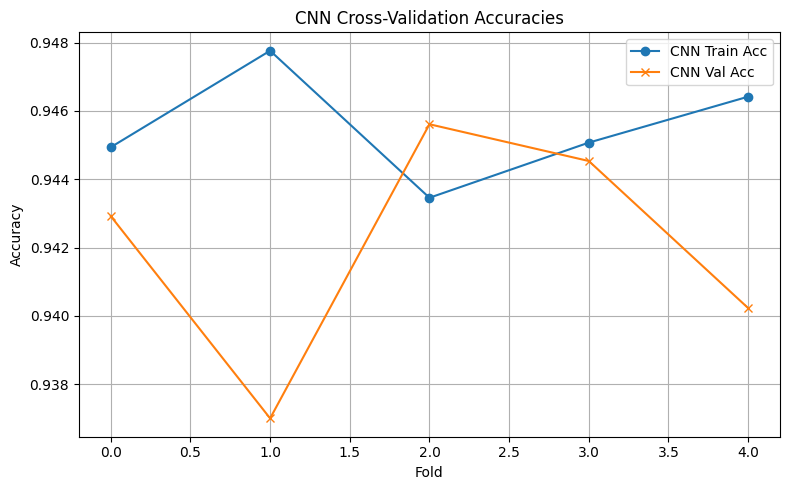

✅ CNN Train Acc Mean: 0.9455, Val Acc Mean: 0.9421, Overfit Gap: 0.0035


In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load your final training dataset (already includes CDL + C2 + RSS balanced)
df_train = pd.read_csv("final_train_data.csv")

# Preprocess
LABEL_COL = "FormalyDiognosedWithASD"
drop_cols = ["HowDiognosisDone", "date", "Class", "FormalDiognosisRecieved", "Ethnicity", "User", "Score",
             "FamilyASDHistory", "AutismAgeCategory", "time", "month", "day", "year", "id"]
df_train.drop(columns=[c for c in drop_cols if c in df_train.columns], inplace=True)

X = df_train.drop(columns=[LABEL_COL])
y = df_train[LABEL_COL].astype(int)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Classical models
overfit_summary = []
models = {
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=8, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=500, random_state=42),
    'SVM': SVC(C=0.1, kernel='rbf', gamma='auto', probability=True, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=150, max_depth=7, subsample=0.6, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=100),
    'Naive Bayes': GaussianNB(),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, learning_rate=0.5, random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42),
    'LightGBM': LGBMClassifier(n_estimators=200, random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42)
}

for name, model in models.items():
    train_scores = []
    val_scores = []
    for train_idx, val_idx in cv.split(X_scaled, y):
        X_tr, X_val = X_scaled[train_idx], X_scaled[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_tr, y_tr)
        train_acc = accuracy_score(y_tr, model.predict(X_tr))
        val_acc = accuracy_score(y_val, model.predict(X_val))

        train_scores.append(train_acc)
        val_scores.append(val_acc)

    overfit_summary.append({
        "Model": name,
        "Train Accuracy (mean)": np.mean(train_scores),
        "Val Accuracy (mean)": np.mean(val_scores),
        "Overfitting Gap": np.mean(train_scores) - np.mean(val_scores)
    })

df_overfit = pd.DataFrame(overfit_summary)
print(df_overfit.sort_values("Overfitting Gap", ascending=False))

# Plot classical model overfitting
plt.figure(figsize=(12, 6))
plt.bar(df_overfit["Model"], df_overfit["Overfitting Gap"], color='tomato')
plt.title("Overfitting Gap per Model (Train Acc - Val Acc)")
plt.ylabel("Overfitting Gap")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("model_overfitting_gaps.png")
plt.show()

# CNN model cross-validation

def create_cnn(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.4),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

cnn_train_accs = []
cnn_val_accs = []
for fold, (train_idx, val_idx) in enumerate(cv.split(X_scaled, y)):
    print(f"🔁 CNN Fold {fold + 1}")
    X_tr, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_tr, y_val = y.iloc[train_idx].values, y.iloc[val_idx].values

    cnn_model = create_cnn(X_tr.shape[1])
    history = cnn_model.fit(X_tr, y_tr, validation_data=(X_val, y_val),
                            epochs=15, batch_size=32, verbose=0)

    cnn_train_accs.append(history.history['accuracy'][-1])
    cnn_val_accs.append(history.history['val_accuracy'][-1])

plt.figure(figsize=(8, 5))
plt.plot(cnn_train_accs, label='CNN Train Acc', marker='o')
plt.plot(cnn_val_accs, label='CNN Val Acc', marker='x')
plt.title("CNN Cross-Validation Accuracies")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("cnn_cv_overfitting_check.png")
plt.show()

print(f"✅ CNN Train Acc Mean: {np.mean(cnn_train_accs):.4f}, Val Acc Mean: {np.mean(cnn_val_accs):.4f}, Overfit Gap: {np.mean(cnn_train_accs) - np.mean(cnn_val_accs):.4f}")


[LightGBM] [Info] Number of positive: 4721, number of negative: 2707
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 110
[LightGBM] [Info] Number of data points in the train set: 7428, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.635568 -> initscore=0.556180
[LightGBM] [Info] Start training from score 0.556180
[LightGBM] [Info] Number of positive: 4721, number of negative: 2707
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000358 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 109
[LightGBM] [Info] Number of data points in the train set: 7428, number of used features: 14
[LightGBM] [Info] [binary:Bo

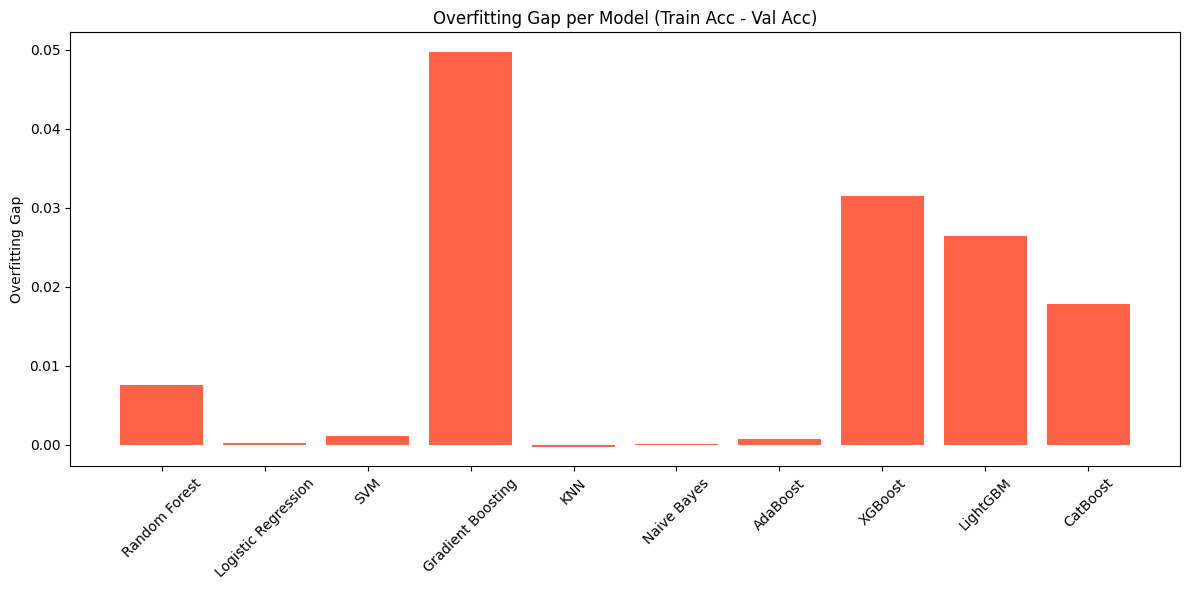

🔁 CNN Fold 1
🔁 CNN Fold 2
🔁 CNN Fold 3
🔁 CNN Fold 4
🔁 CNN Fold 5
✅ CNN Test Accuracy on C3: 0.8250


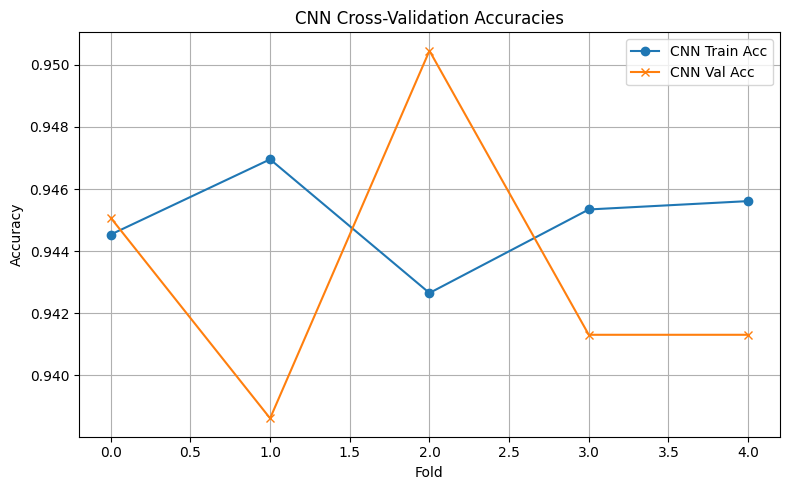

                  Model  Train Accuracy (mean)  Val Accuracy (mean)  \
3     Gradient Boosting               0.978971             0.929241   
7               XGBoost               0.967878             0.936349   
8              LightGBM               0.961497             0.935057   
9              CatBoost               0.958104             0.940334   
0         Random Forest               0.944723             0.937103   
10                  CNN               0.945019             0.943350   
2                   SVM               0.928783             0.927733   
6              AdaBoost               0.930452             0.929672   
1   Logistic Regression               0.935972             0.935703   
5           Naive Bayes               0.925094             0.925040   
4                   KNN               0.932122             0.932364   

    Overfitting Gap  Test Accuracy (C3)  
3          0.049731            0.806890  
7          0.031529            0.815956  
8          0.026440  

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load your final training dataset and test dataset (C3)
df_train = pd.read_csv("final_train_data.csv")
df_test = pd.read_csv("Updated_C3_Datanew.csv")

# Preprocess
LABEL_COL = "FormalyDiognosedWithASD"
drop_cols = ["HowDiognosisDone", "date", "Class", "FormalDiognosisRecieved", "Ethnicity", "User", "Score",
             "FamilyASDHistory", "AutismAgeCategory", "time", "month", "day", "year", "id"]
for df in [df_train, df_test]:
    df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True)

X_train = df_train.drop(columns=[LABEL_COL])
y_train = df_train[LABEL_COL].astype(int)
X_test = df_test.drop(columns=[LABEL_COL])
y_test = df_test[LABEL_COL].astype(int)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Classical models
overfit_summary = []
test_accuracies = []
models = {
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=8, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=500, random_state=42),
    'SVM': SVC(C=0.1, kernel='rbf', gamma='auto', probability=True, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=150, max_depth=7, subsample=0.6, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=100),
    'Naive Bayes': GaussianNB(),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, learning_rate=0.5, random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42),
    'LightGBM': LGBMClassifier(n_estimators=200, random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42)
}

for name, model in models.items():
    train_scores = []
    val_scores = []
    for train_idx, val_idx in cv.split(X_train_scaled, y_train):
        X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_tr, y_tr)
        train_acc = accuracy_score(y_tr, model.predict(X_tr))
        val_acc = accuracy_score(y_val, model.predict(X_val))

        train_scores.append(train_acc)
        val_scores.append(val_acc)

    # Fit on full training data and evaluate on C3
    model.fit(X_train_scaled, y_train)
    test_acc = accuracy_score(y_test, model.predict(X_test_scaled))
    test_accuracies.append((name, test_acc))

    overfit_summary.append({
        "Model": name,
        "Train Accuracy (mean)": np.mean(train_scores),
        "Val Accuracy (mean)": np.mean(val_scores),
        "Overfitting Gap": np.mean(train_scores) - np.mean(val_scores),
        "Test Accuracy (C3)": test_acc
    })

df_overfit = pd.DataFrame(overfit_summary)
print(df_overfit.sort_values("Overfitting Gap", ascending=False))

# Plot classical model overfitting
plt.figure(figsize=(12, 6))
plt.bar(df_overfit["Model"], df_overfit["Overfitting Gap"], color='tomato')
plt.title("Overfitting Gap per Model (Train Acc - Val Acc)")
plt.ylabel("Overfitting Gap")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("model_overfitting_gaps.png")
plt.show()

# CNN model cross-validation and testing

def create_cnn(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.4),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

cnn_train_accs = []
cnn_val_accs = []
for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_scaled, y_train)):
    print(f"🔁 CNN Fold {fold + 1}")
    X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_tr, y_val = y_train.iloc[train_idx].values, y_train.iloc[val_idx].values

    cnn_model = create_cnn(X_tr.shape[1])
    history = cnn_model.fit(X_tr, y_tr, validation_data=(X_val, y_val),
                            epochs=15, batch_size=32, verbose=0)

    cnn_train_accs.append(history.history['accuracy'][-1])
    cnn_val_accs.append(history.history['val_accuracy'][-1])

# Final CNN testing on C3
test_model = create_cnn(X_train_scaled.shape[1])
test_model.fit(X_train_scaled, y_train, epochs=15, batch_size=32, verbose=0)
test_acc = test_model.evaluate(X_test_scaled, y_test, verbose=0)[1]
print(f"✅ CNN Test Accuracy on C3: {test_acc:.4f}")
df_overfit = pd.concat([df_overfit, pd.DataFrame([{
    "Model": "CNN",
    "Train Accuracy (mean)": np.mean(cnn_train_accs),
    "Val Accuracy (mean)": np.mean(cnn_val_accs),
    "Overfitting Gap": np.mean(cnn_train_accs) - np.mean(cnn_val_accs),
    "Test Accuracy (C3)": test_acc
}])], ignore_index=True)

plt.figure(figsize=(8, 5))
plt.plot(cnn_train_accs, label='CNN Train Acc', marker='o')
plt.plot(cnn_val_accs, label='CNN Val Acc', marker='x')
plt.title("CNN Cross-Validation Accuracies")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("cnn_cv_overfitting_check.png")
plt.show()

print(df_overfit.sort_values("Overfitting Gap", ascending=False))


[LightGBM] [Info] Number of positive: 4721, number of negative: 2707
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 110
[LightGBM] [Info] Number of data points in the train set: 7428, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.635568 -> initscore=0.556180
[LightGBM] [Info] Start training from score 0.556180
[LightGBM] [Info] Number of positive: 4721, number of negative: 2707
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000603 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 109
[LightGBM] [Info] Number of data points in the train set: 7428, number of used features: 14
[LightGBM] [Info] [binary:Bo

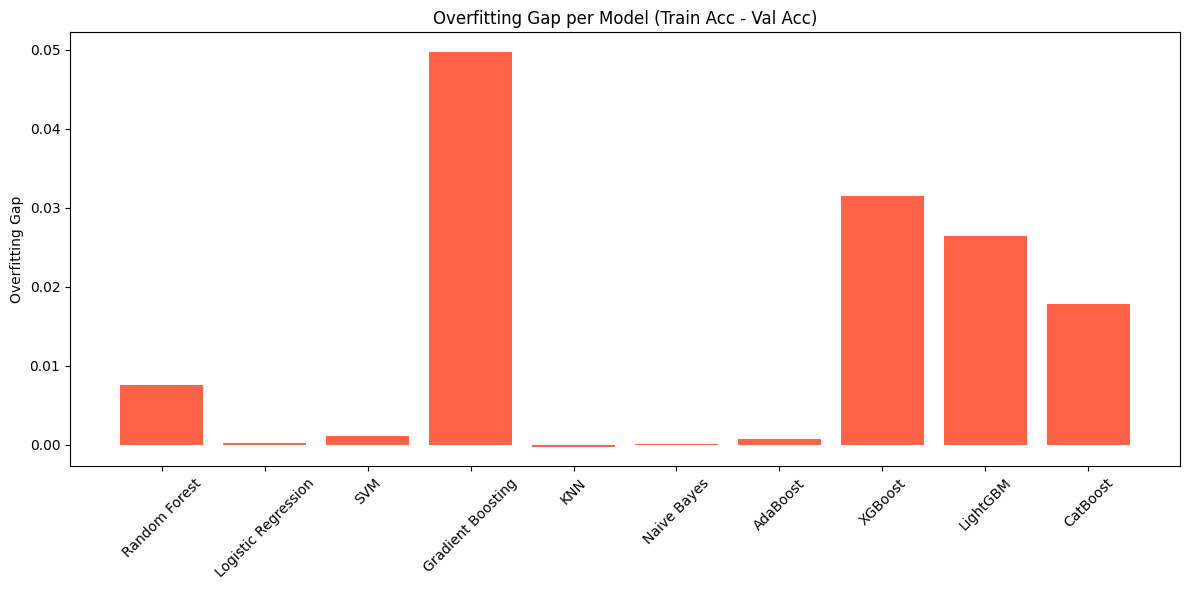

🔁 CNN Fold 1
🔁 CNN Fold 2
🔁 CNN Fold 3
🔁 CNN Fold 4
🔁 CNN Fold 5
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
✅ CNN Test Accuracy on C3: 0.8205


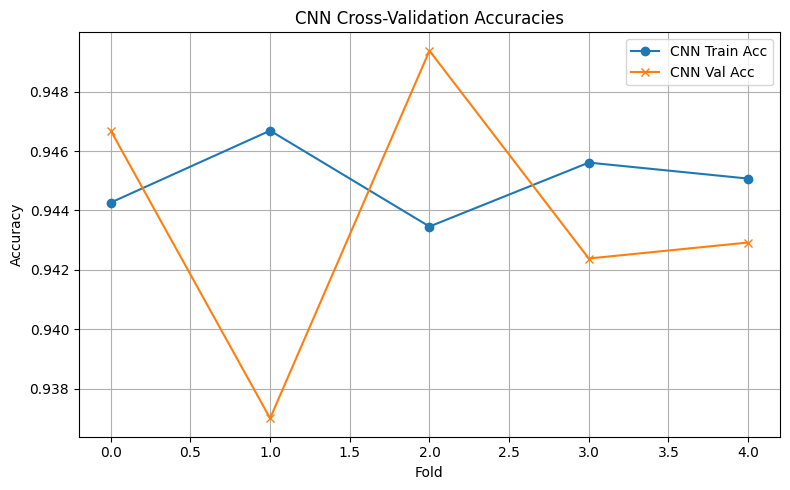

                  Model  Train Accuracy (mean)  Val Accuracy (mean)  \
3     Gradient Boosting               0.978971             0.929241   
7               XGBoost               0.967878             0.936349   
8              LightGBM               0.961497             0.935057   
9              CatBoost               0.958104             0.940334   
0         Random Forest               0.944723             0.937103   
10                  CNN               0.945019             0.943673   
2                   SVM               0.928783             0.927733   
6              AdaBoost               0.930452             0.929672   
1   Logistic Regression               0.935972             0.935703   
5           Naive Bayes               0.925094             0.925040   
4                   KNN               0.932122             0.932364   

    Overfitting Gap  Test Accuracy (C3)  Sensitivity  Specificity   ROC-AUC  
3          0.049731            0.806890     0.763848     0.877698  0.

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load your final training dataset and test dataset (C3)
df_train = pd.read_csv("final_train_data.csv")
df_test = pd.read_csv("Updated_C3_Datanew.csv")
original_df_test = pd.read_csv("Updated_C3_Datanew.csv")  # To retain AutismAgeCategory

# Preprocess
LABEL_COL = "FormalyDiognosedWithASD"
drop_cols = ["HowDiognosisDone", "date", "Class", "FormalDiognosisRecieved", "Ethnicity", "User", "Score",
             "FamilyASDHistory", "AutismAgeCategory", "time", "month", "day", "year", "id"]
for df in [df_train, df_test]:
    df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True)

X_train = df_train.drop(columns=[LABEL_COL])
y_train = df_train[LABEL_COL].astype(int)
X_test = df_test.drop(columns=[LABEL_COL])
y_test = df_test[LABEL_COL].astype(int)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Classical models
overfit_summary = []
models = {
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=8, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=500, random_state=42),
    'SVM': SVC(C=0.1, kernel='rbf', gamma='auto', probability=True, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=150, max_depth=7, subsample=0.6, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=100),
    'Naive Bayes': GaussianNB(),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, learning_rate=0.5, random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42),
    'LightGBM': LGBMClassifier(n_estimators=200, random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42)
}

for name, model in models.items():
    train_scores = []
    val_scores = []
    for train_idx, val_idx in cv.split(X_train_scaled, y_train):
        X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_tr, y_tr)
        train_acc = accuracy_score(y_tr, model.predict(X_tr))
        val_acc = accuracy_score(y_val, model.predict(X_val))

        train_scores.append(train_acc)
        val_scores.append(val_acc)

    # Final training and test evaluation
    model.fit(X_train_scaled, y_train)
    y_pred_test = model.predict(X_test_scaled)
    test_acc = accuracy_score(y_test, y_pred_test)
    sensitivity = recall_score(y_test, y_pred_test)
    specificity = recall_score(y_test, y_pred_test, pos_label=0)
    roc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:,1])

    overfit_summary.append({
        "Model": name,
        "Train Accuracy (mean)": np.mean(train_scores),
        "Val Accuracy (mean)": np.mean(val_scores),
        "Overfitting Gap": np.mean(train_scores) - np.mean(val_scores),
        "Test Accuracy (C3)": test_acc,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
        "ROC-AUC": roc
    })

df_overfit = pd.DataFrame(overfit_summary)
print(df_overfit.sort_values("Overfitting Gap", ascending=False))

# Plot classical model overfitting
plt.figure(figsize=(12, 6))
plt.bar(df_overfit["Model"], df_overfit["Overfitting Gap"], color='tomato')
plt.title("Overfitting Gap per Model (Train Acc - Val Acc)")
plt.ylabel("Overfitting Gap")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("model_overfitting_gaps.png")
plt.show()

# CNN model cross-validation and testing

def create_cnn(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.4),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

cnn_train_accs = []
cnn_val_accs = []
for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_scaled, y_train)):
    print(f"🔁 CNN Fold {fold + 1}")
    X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_tr, y_val = y_train.iloc[train_idx].values, y_train.iloc[val_idx].values

    cnn_model = create_cnn(X_tr.shape[1])
    history = cnn_model.fit(X_tr, y_tr, validation_data=(X_val, y_val),
                            epochs=15, batch_size=32, verbose=0)

    cnn_train_accs.append(history.history['accuracy'][-1])
    cnn_val_accs.append(history.history['val_accuracy'][-1])

# Final CNN testing on C3
test_model = create_cnn(X_train_scaled.shape[1])
test_model.fit(X_train_scaled, y_train, epochs=15, batch_size=32, verbose=0)
cnn_probs = test_model.predict(X_test_scaled).flatten()
cnn_preds = (cnn_probs >= 0.5).astype(int)
test_acc = accuracy_score(y_test, cnn_preds)
sensitivity = recall_score(y_test, cnn_preds)
specificity = recall_score(y_test, cnn_preds, pos_label=0)
roc = roc_auc_score(y_test, cnn_probs)
print(f"✅ CNN Test Accuracy on C3: {test_acc:.4f}")

# Add CNN to summary
df_overfit = pd.concat([df_overfit, pd.DataFrame([{
    "Model": "CNN",
    "Train Accuracy (mean)": np.mean(cnn_train_accs),
    "Val Accuracy (mean)": np.mean(cnn_val_accs),
    "Overfitting Gap": np.mean(cnn_train_accs) - np.mean(cnn_val_accs),
    "Test Accuracy (C3)": test_acc,
    "Sensitivity": sensitivity,
    "Specificity": specificity,
    "ROC-AUC": roc
}])], ignore_index=True)

plt.figure(figsize=(8, 5))
plt.plot(cnn_train_accs, label='CNN Train Acc', marker='o')
plt.plot(cnn_val_accs, label='CNN Val Acc', marker='x')
plt.title("CNN Cross-Validation Accuracies")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("cnn_cv_overfitting_check.png")
plt.show()

print(df_overfit.sort_values("Overfitting Gap", ascending=False))

# Age group analysis
original_df_test['Predicted'] = cnn_preds
if 'AutismAgeCategory' in original_df_test.columns:
    age_groups = original_df_test['AutismAgeCategory'].unique()
    print("\n🔍 Age Group Analysis (CNN Predictions):")
    for group in age_groups:
        subset = original_df_test[original_df_test['AutismAgeCategory'] == group]
        print(f"\n📊 Age Group: {group}")
        print(classification_report(subset[LABEL_COL], subset['Predicted'], digits=3))
